In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import scipy as sp
import missingno as msno

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

#machine learning
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [2]:
train_data_path = 'C:/Users/Schindler/Documents/ProgrammingFun/GOSSIS_kaggle/training_v2.csv'
unlabeled_data_path = 'C:/Users/Schindler/Documents/ProgrammingFun/GOSSIS_kaggle/unlabeled.csv'

In [3]:
train_supplied = pd.read_csv(train_data_path)
train_supplied = pd.DataFrame(data = train_supplied)

print('Original data shape:\n', train_supplied.shape, '\n')
print('Group value counts:\n', train_supplied['hospital_death'].value_counts(), '\n')

#remove columns with meta data (e.g. unique identifiers) and/or zero variance
meta_cols = ['encounter_id', 'patient_id', 'readmission_status']
train_supplied = train_supplied.drop(columns = meta_cols)

#convert negative numbers to nans 
cols_with_zeros = ['pre_icu_los_days', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']
train_supplied.loc[~(train_supplied['pre_icu_los_days'] > 0), 'pre_icu_los_days']=np.nan
train_supplied.loc[~(train_supplied['apache_4a_hospital_death_prob'] > 0), 'apache_4a_hospital_death_prob']=np.nan
train_supplied.loc[~(train_supplied['apache_4a_icu_death_prob'] > 0), 'apache_4a_icu_death_prob']=np.nan

train_supplied.head()

Original data shape:
 (91713, 186) 

Group value counts:
 0    83798
1     7915
Name: hospital_death, dtype: int64 



,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,

### explore nans and create related features 

In [4]:
#explore missing data 
data = train_supplied

na_0_mean = (data[data['hospital_death'] == 0].isna().sum() / data[data['hospital_death'] == 0].shape[0] * 100).mean()
na_1_mean = (data[data['hospital_death'] == 1].isna().sum() / data[data['hospital_death'] == 1].shape[0] * 100).mean()
print(na_0_mean, na_1_mean)

#there is a bit more missing data for the entries that lived (not surprizing as you get more tests the poorer health)
#get count of missing data per entry
train_supplied['na_count'] = train_supplied.isna().sum(axis=1)

34.78926750341732 29.67444397267414


In [5]:
#are there parameters that have more missing values for yes vs no death
data = train_supplied

na_0 = (data[data['hospital_death'] == 0].isna().sum() / data[data['hospital_death'] == 0].shape[0]) * 100
na_1 = (data[data['hospital_death'] == 1].isna().sum() / data[data['hospital_death'] == 1].shape[0]) * 100
na_0_diff = data[data['hospital_death'] == 0].shape[0] - data[data['hospital_death'] == 0].isna().sum()
na_1_diff = data[data['hospital_death'] == 1].shape[0] - data[data['hospital_death'] == 1].isna().sum()
data_na_perc = pd.DataFrame(data=[na_0, na_1, na_0_diff, na_1_diff])
data_na_perc = data_na_perc.T.sort_values(by=0, ascending=False)
data_na_perc.columns = ['na_0', 'na_1', 'na_0_diff', 'na_1_diff']
data_na_perc['diff'] = data_na_perc['na_0'] - data_na_perc['na_1']
data_na_perc = data_na_perc.sort_values(by='diff', ascending=False)

#get count for each entry of how many missing for params that have at least 25% difference in missing between yes and no death
param_25_diff = data_na_perc[data_na_perc['diff'] > 25].index
train_supplied['param_25_diff_count'] = train_supplied[param_25_diff].isna().sum(axis=1)

In [6]:
#remove features that have more than 50% missing data
print(train_supplied.shape)
train_missing = (train_supplied.isnull().sum() / len(train_supplied)).sort_values(ascending = False)
train_missing = train_missing.index[train_missing > 0.50]
print('There are %d columns with more than 50%% missing values' % len(train_missing))
train_supplied_missing = train_supplied.copy().drop(columns = train_missing)
print(train_supplied_missing.shape)

(91713, 185)
There are 74 columns with more than 50% missing values
(91713, 111)


### encode categorical variables

In [7]:
#convert categorical columns that are ints to categorical dtype
train_supplied_missing['hospital_id'] = train_supplied_missing['hospital_id'].astype('category')
train_supplied_missing['age'] = train_supplied_missing['age'].astype('category')
train_supplied_missing['icu_id'] = train_supplied_missing['icu_id'].astype('category')

#encode categorical variables
cat_cols = ['hospital_id', 'age', 'icu_id', 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 
            'icu_type', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_3j_bodysystem', 'apache_2_bodysystem']

#encode categorical variables using targetencoder - will need to retrain on fianl feature set
data_cat_train = train_supplied_missing.copy()

Y_train = data_cat_train['hospital_death']
X_train = data_cat_train

# use target encoding to encode two categorical features
enc = ce.TargetEncoder(cols=cat_cols, handle_missing='return_nan', handle_unknown='return_nan').fit(X_train, Y_train)
train_supplied_missing_catenc = enc.transform(X_train)
print(train_supplied_missing_catenc.shape)
train_supplied_missing_catenc.head()

(91713, 111)


,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,na_count,param_25_diff_count
0,0.070621,0,0.090658,22.73,0,0.087262,0.084417,180.3,0.138796,0.134136,0.027242,0.085168,0.060205,0.541667,73.9,0.157922,0.104856,0,0.0,31.0,2.51,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,36.0,134.0,39.3,0.0,14.1,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,73.0,39.9,37.2,68.0,63.0,68.0,63.0,119.0,108.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,131.0,115.0,39.5,37.5,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.157922,0.108383,60,13
1,0.043103,0,0.113648,27.42,0,0.087262,0.088373,160.0,0.138796,0.134136,0.043103,0.085168,0.087495,0.927778,70.2,0.197111,0.197111,0,0.0,9.0,0.56,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,33.0,145.0,35.1,1.0,12.7,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,67.0,36.3,35.1,61.0,48.0,61.0,48.0,114.0,100.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,95.0,71.0,36.3,36.3,11.0,9.0,8.6,8.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.112068,0.112068,19,0
2,0.070621,0,0.021687,31.95,0,0.087262,0.088373,172.7,0.087306,0.086385,0.067093,0.085168,0.087495,0.000694,95.3,0.008493,0.007727,0,0.0,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0.0,68.0,37.0,NaN,36.7,0.0,NaN,88.0,48.0,88.0,48.0,96.0,68.0,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,148.0,105.0,148.0,105.0,37.0,36.7,88.0,58.0,88.0,58.0,96.0,78.0,91.0,83.0,91.0,83.0,20.0,16.0,98.0,91.0,148.0,124.0,148.0,124.0,36.7,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015163,0.015163,104,15
3,0.070621,0,0.112583,22.64,1,0.087262,0.088373,165.1,0.035251,0.037300,0.027242,0.085168,0.060205,0.000694,61.7,0.028886,0.019481,1,0.0,NaN,NaN,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1.0,60.0,4.0,NaN,34.8,1.0,8.0,48.0,42.0,48.0,42.0,116.0,92.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,158.0,84.0,158.0,84.0,38.0,34.8,62.0,44.0,NaN,NaN,100.0,96.0,92.0,71.0,NaN,NaN,12.0,11.0,100.0,99.0,136.0,106.0,NaN,NaN,35.6,34.8,NaN,NaN,NaN,NaN,NaN,NaN,185.0,88.0,NaN,NaN,11.6,8.9,34.0,25.9,198.0,43.0,5.0,3.5,NaN,NaN,

In [35]:
#create feature that is count of disease diagnosis
diseases = ['aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'arf_apache']

train_supplied_missing_catenc['disease_count'] = train_supplied_missing_catenc[diseases].dropna().sum(axis=1)

#create feature that is sum of gcs scores
gcs_params = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache']

train_supplied_missing_catenc['gcs_sum'] = train_supplied_missing_catenc[gcs_params].dropna().sum(axis=1)


### explore and remove outliers

hospital_id


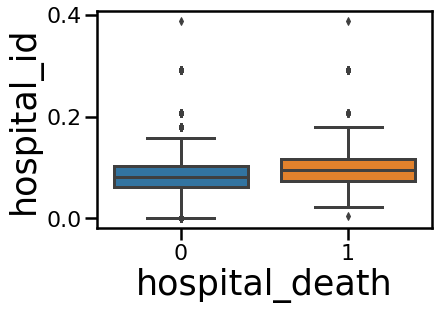

hospital_death


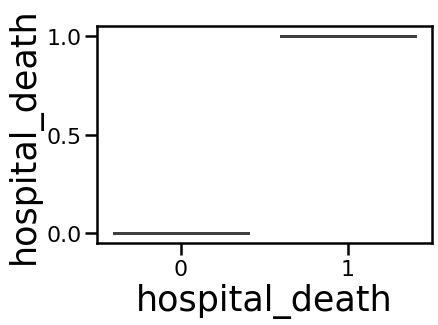

age


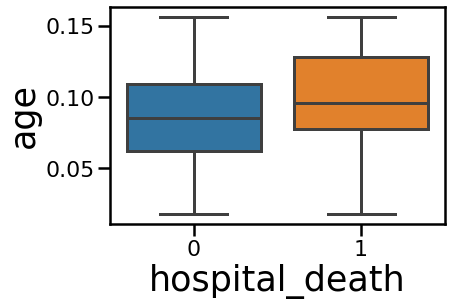

bmi


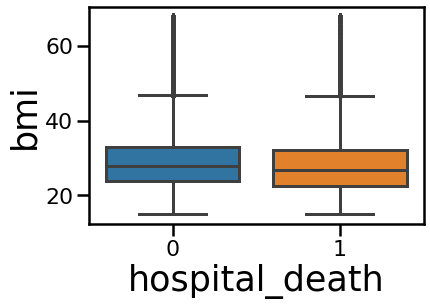

elective_surgery


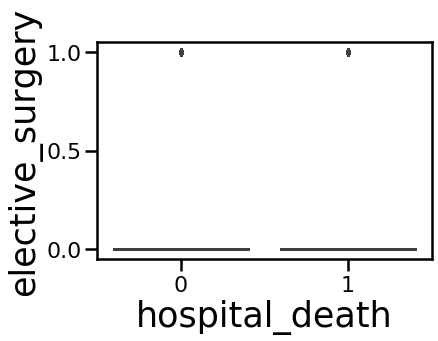

ethnicity


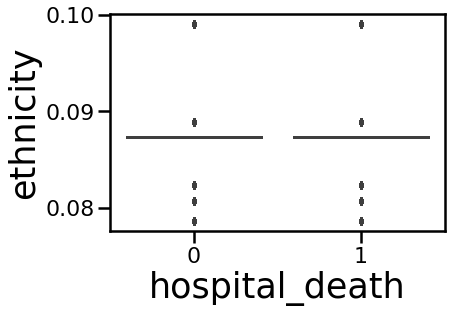

gender


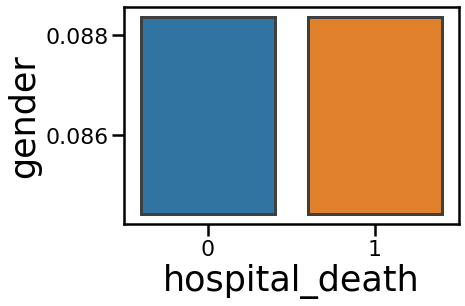

height


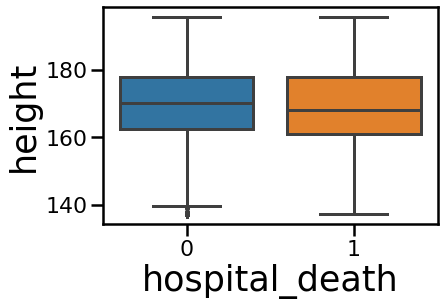

hospital_admit_source


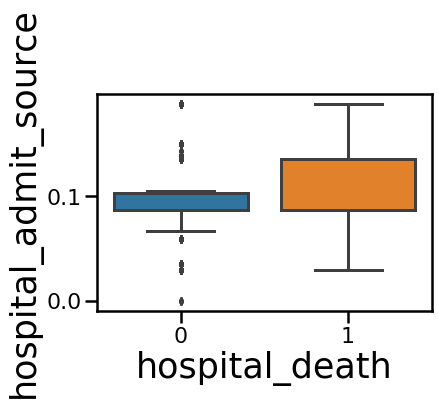

icu_admit_source


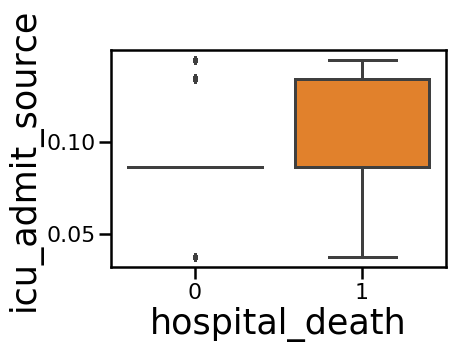

icu_id


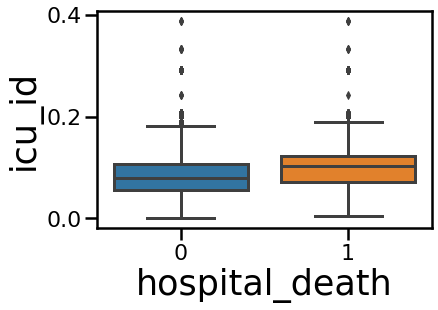

icu_stay_type


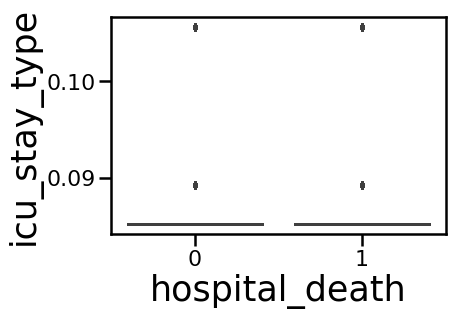

icu_type


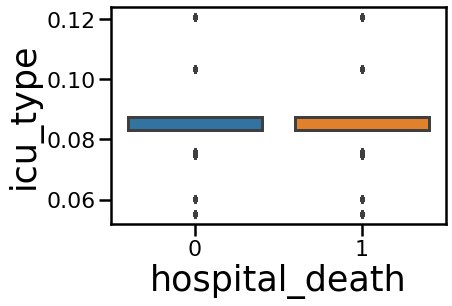

pre_icu_los_days


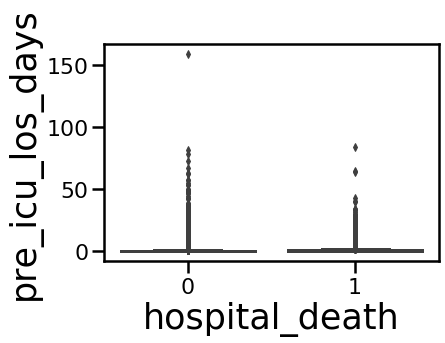

weight


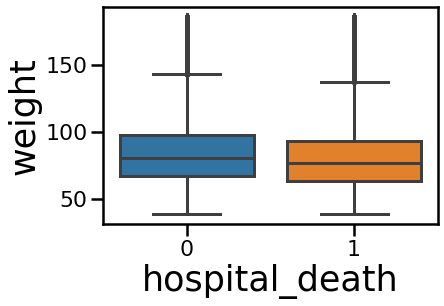

apache_2_diagnosis


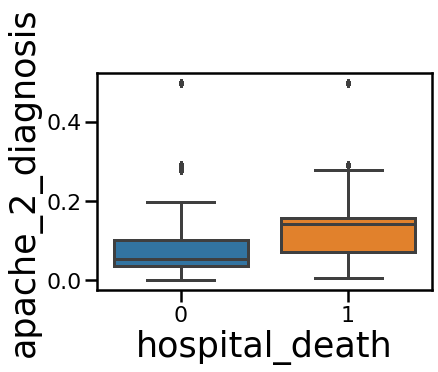

apache_3j_diagnosis


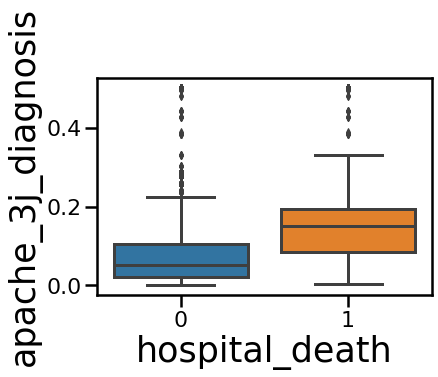

apache_post_operative


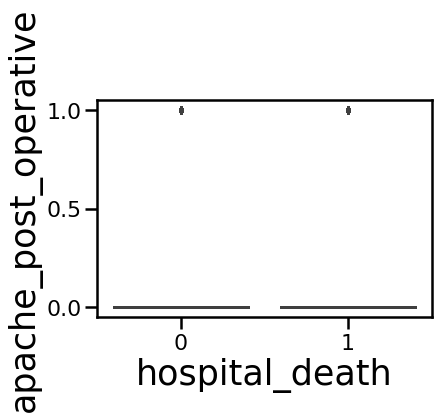

arf_apache


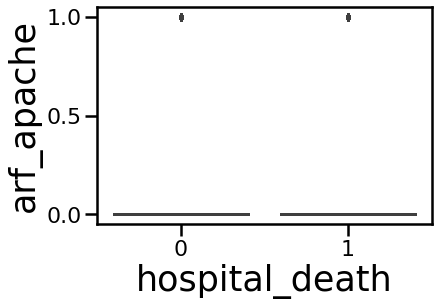

bun_apache


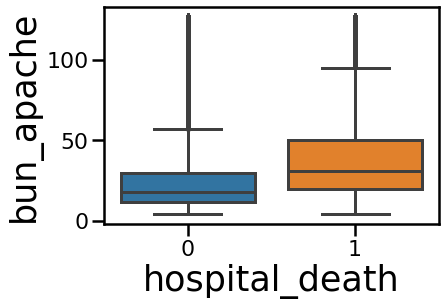

creatinine_apache


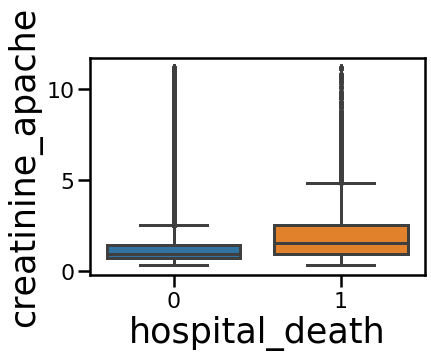

gcs_eyes_apache


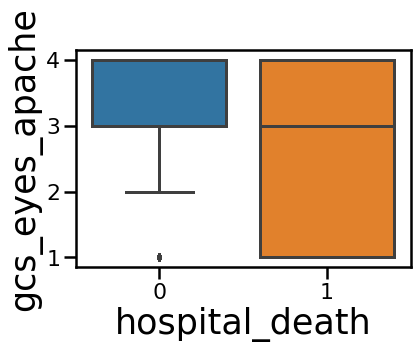

gcs_motor_apache


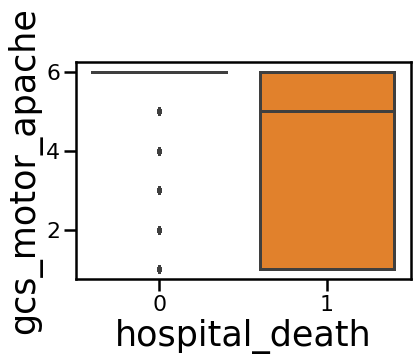

gcs_unable_apache


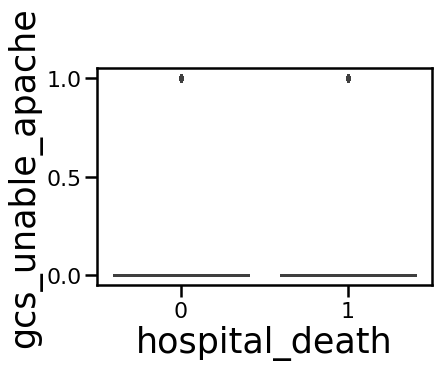

gcs_verbal_apache


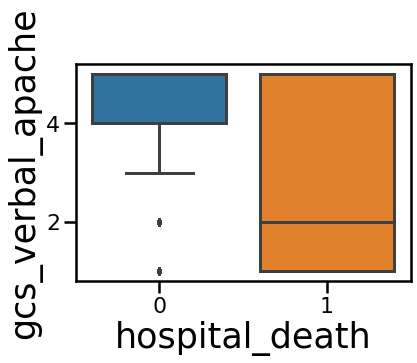

glucose_apache


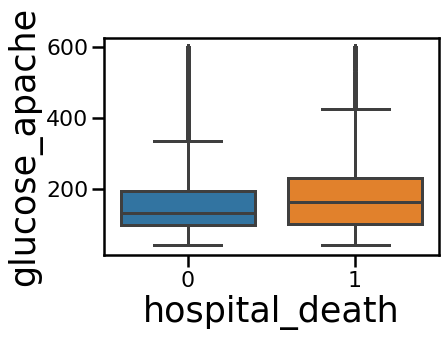

heart_rate_apache


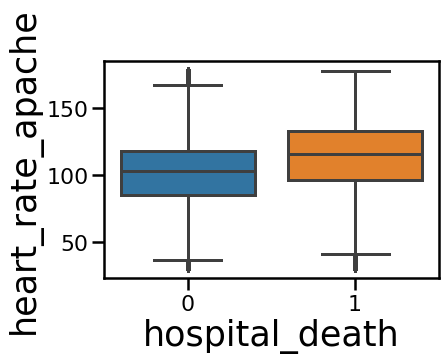

hematocrit_apache


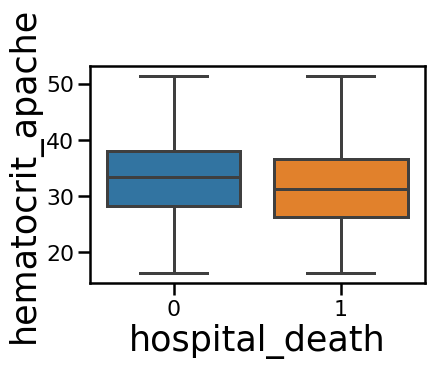

intubated_apache


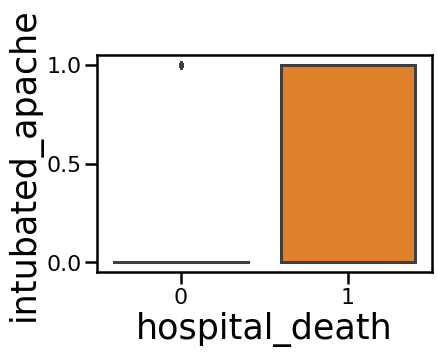

map_apache


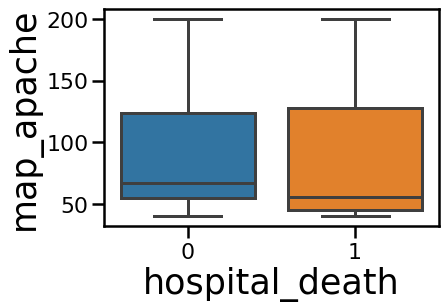

resprate_apache


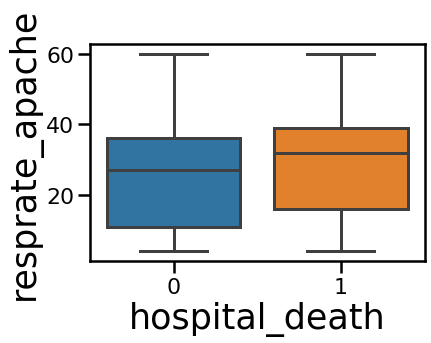

sodium_apache


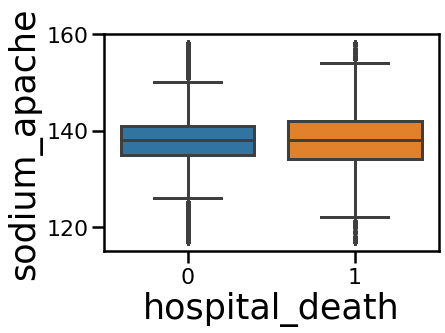

temp_apache


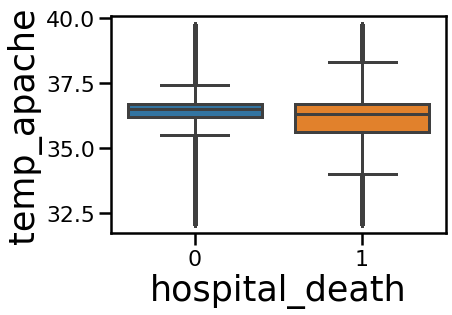

ventilated_apache


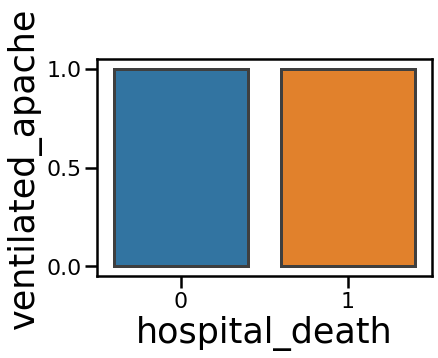

wbc_apache


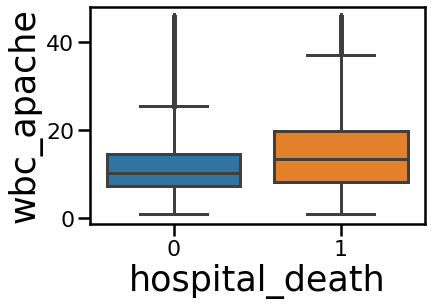

d1_diasbp_max


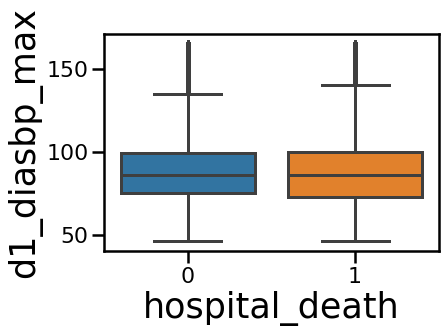

d1_diasbp_min


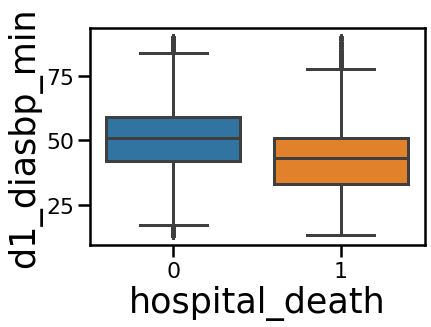

d1_diasbp_noninvasive_max


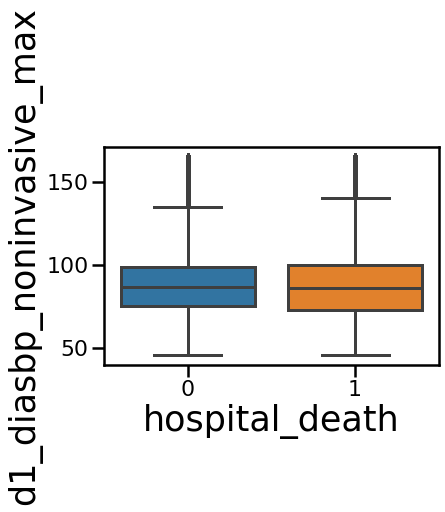

d1_diasbp_noninvasive_min


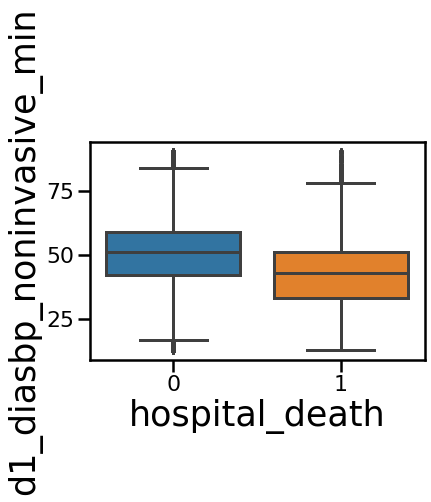

d1_heartrate_max


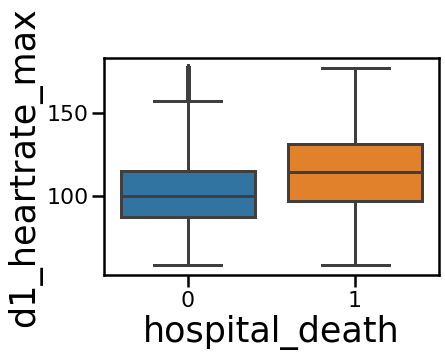

d1_heartrate_min


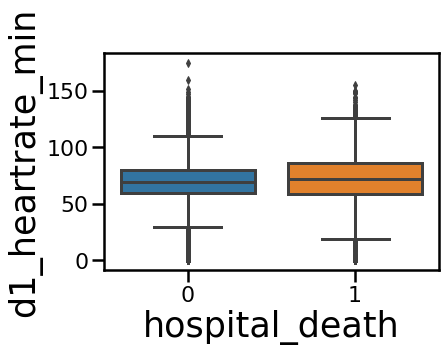

d1_mbp_max


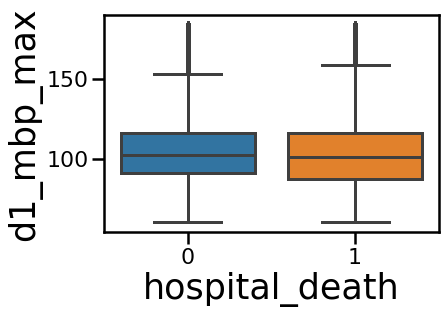

d1_mbp_min


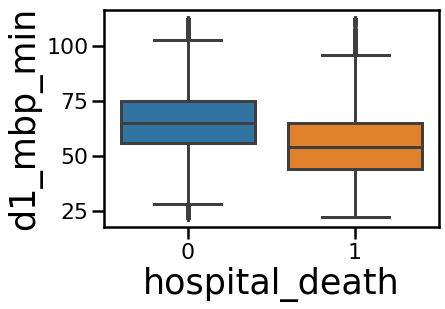

d1_mbp_noninvasive_max


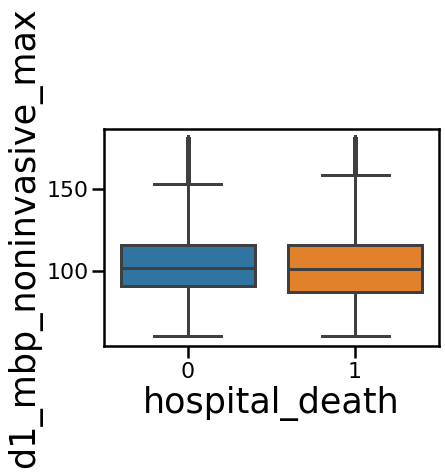

d1_mbp_noninvasive_min


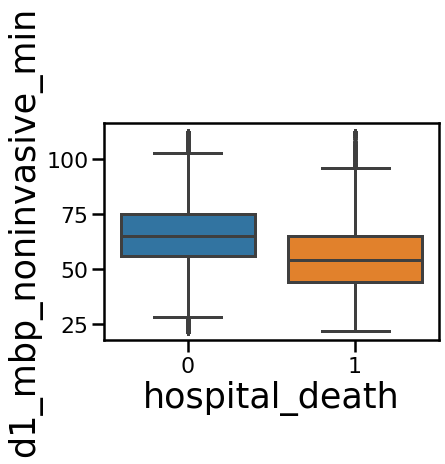

d1_resprate_max


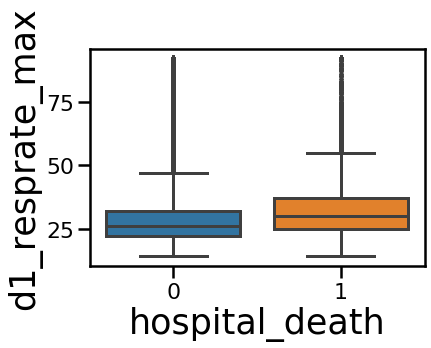

d1_resprate_min


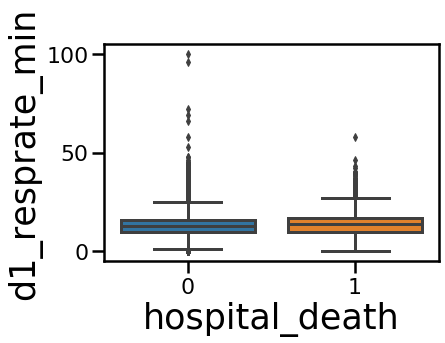

d1_spo2_max


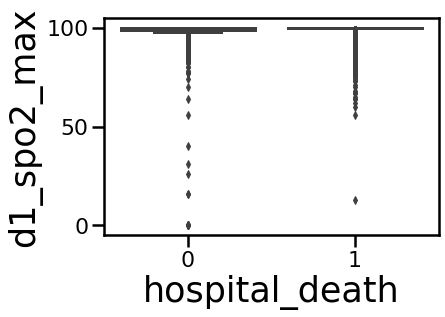

d1_spo2_min


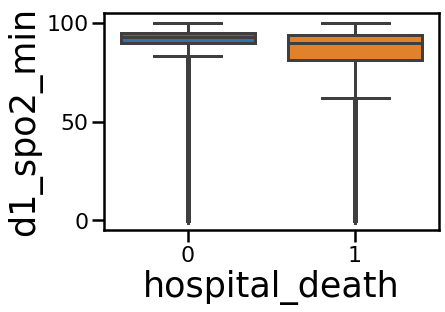

d1_sysbp_max


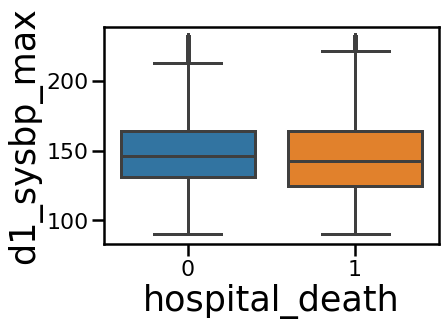

d1_sysbp_min


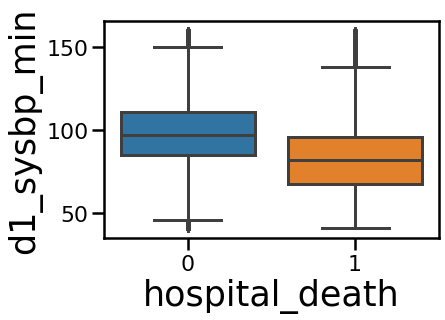

d1_sysbp_noninvasive_max


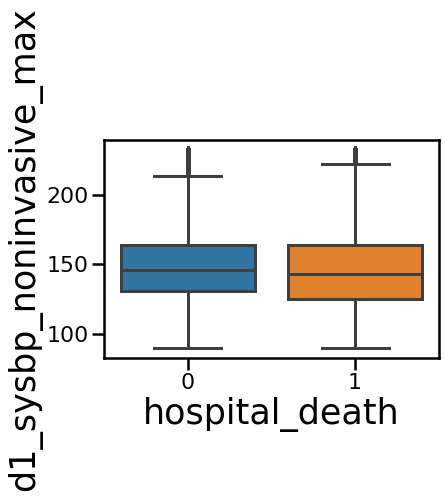

d1_sysbp_noninvasive_min


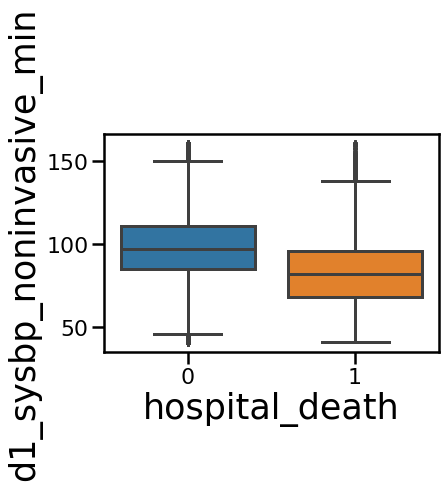

d1_temp_max


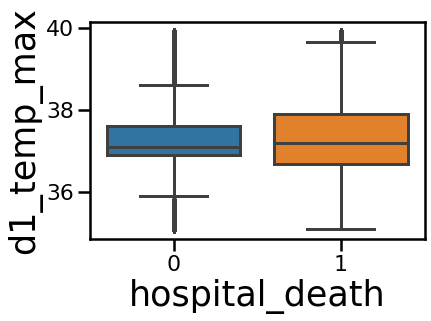

d1_temp_min


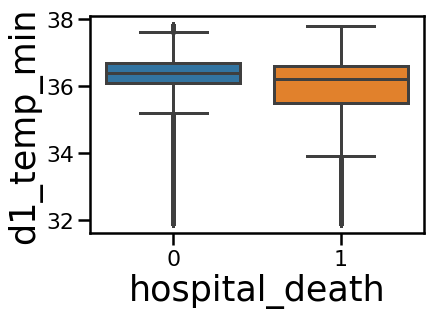

h1_diasbp_max


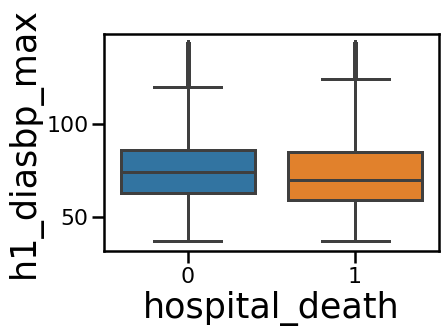

h1_diasbp_min


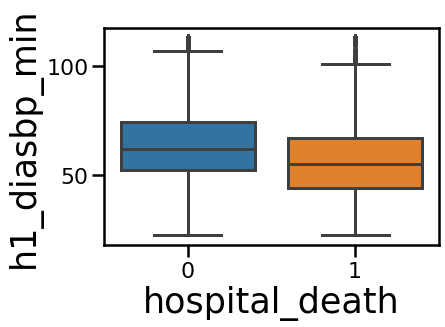

h1_diasbp_noninvasive_max


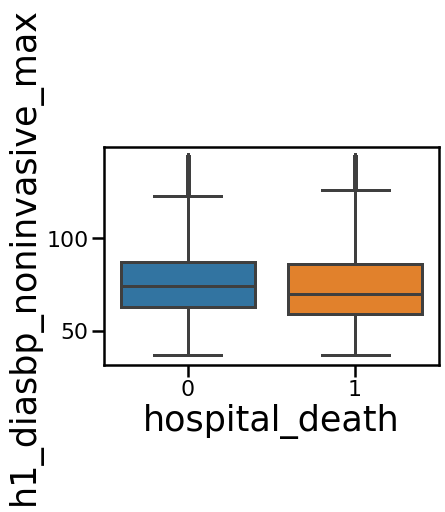

h1_diasbp_noninvasive_min


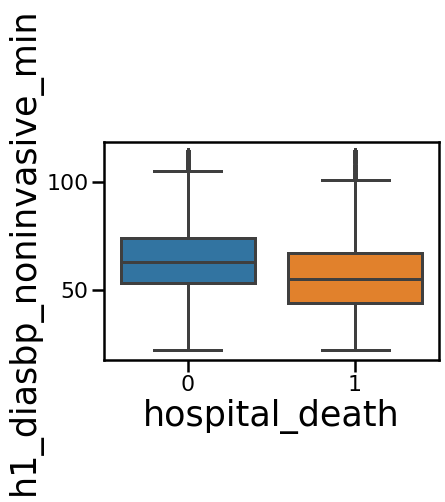

h1_heartrate_max


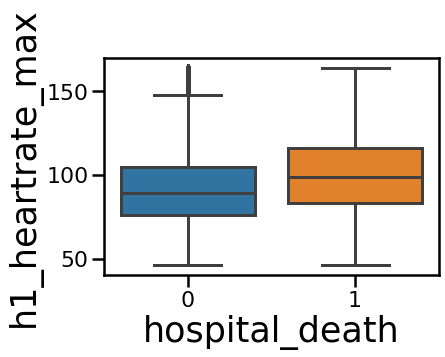

h1_heartrate_min


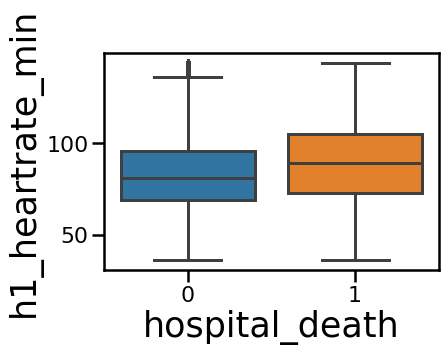

h1_mbp_max


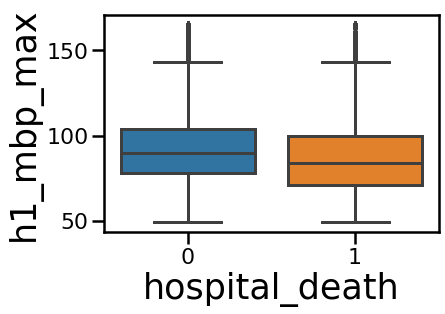

h1_mbp_min


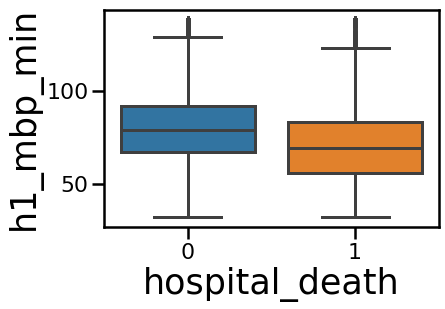

h1_mbp_noninvasive_max


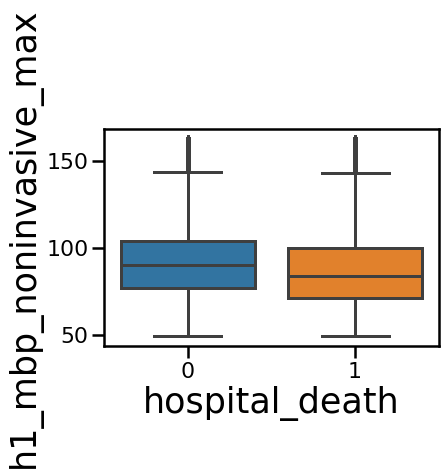

h1_mbp_noninvasive_min


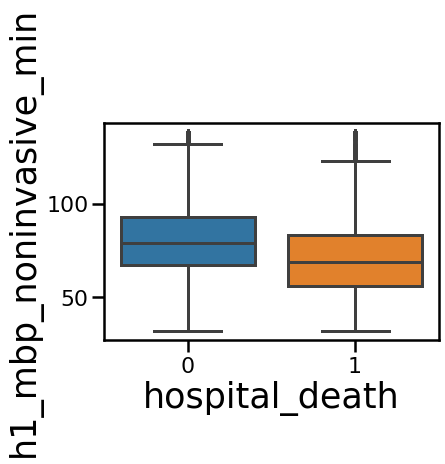

h1_resprate_max


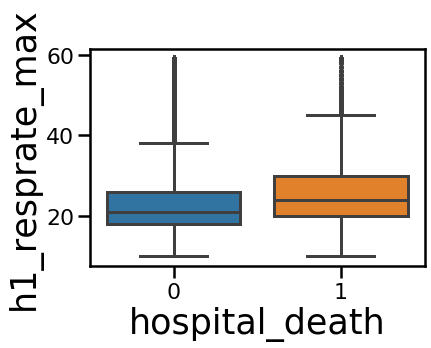

h1_resprate_min


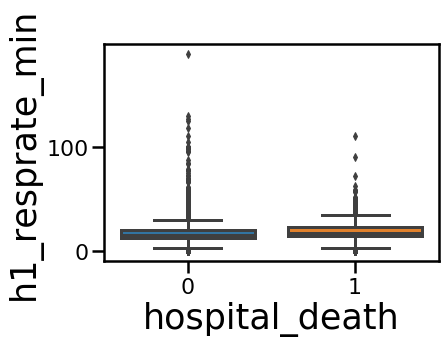

h1_spo2_max


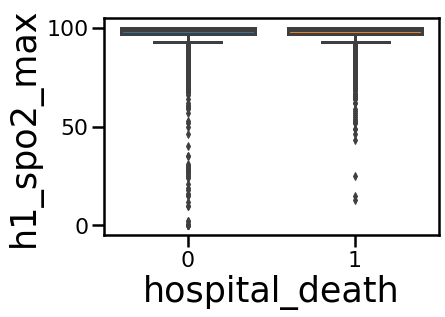

h1_spo2_min


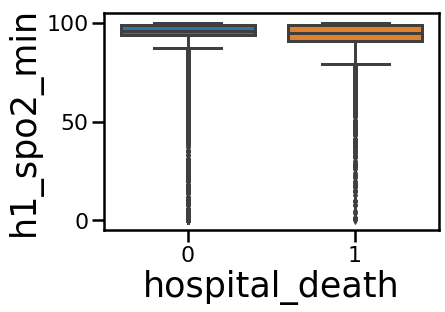

h1_sysbp_max


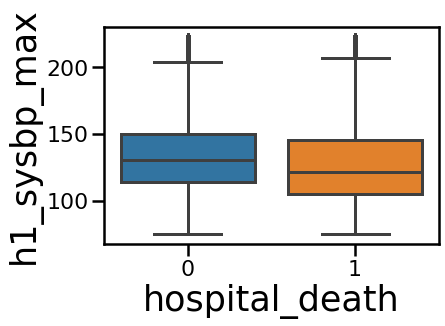

h1_sysbp_min


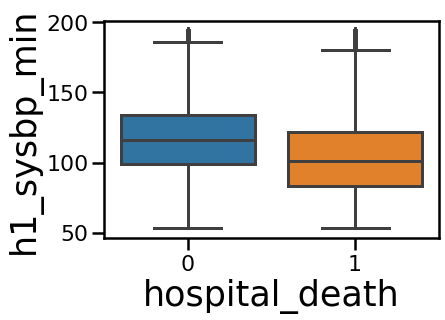

h1_sysbp_noninvasive_max


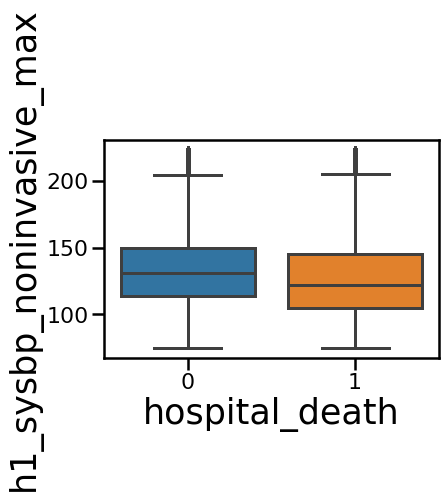

h1_sysbp_noninvasive_min


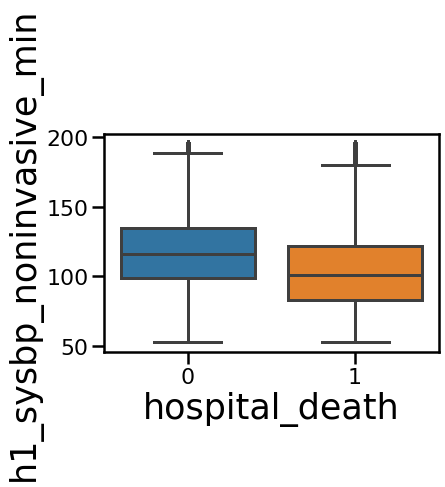

h1_temp_max


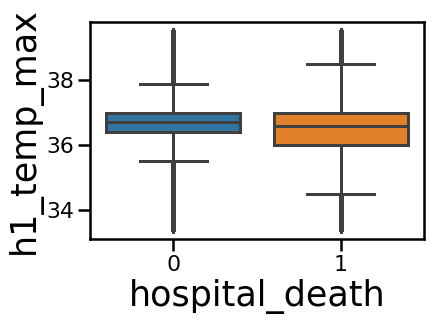

h1_temp_min


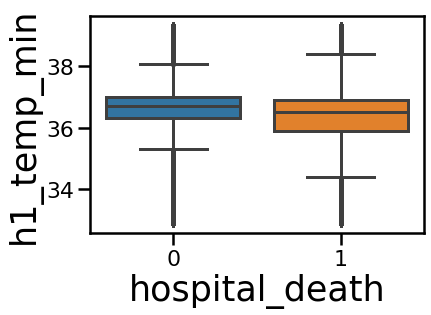

d1_bun_max


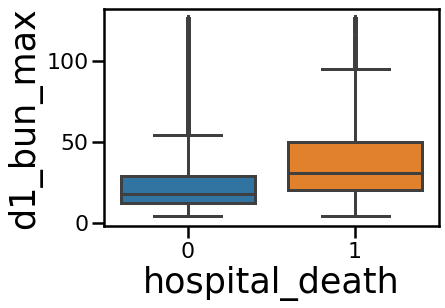

d1_bun_min


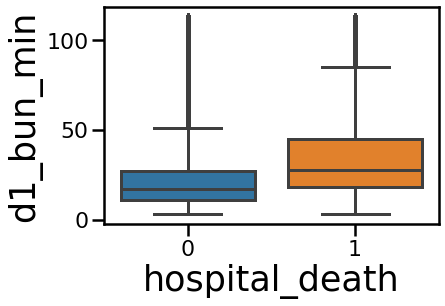

d1_calcium_max


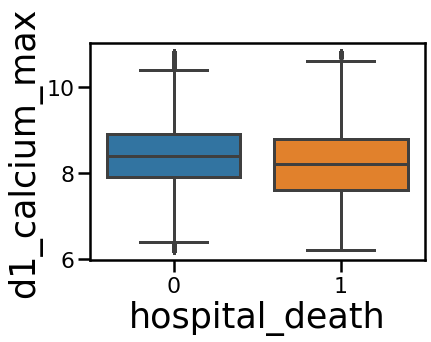

d1_calcium_min


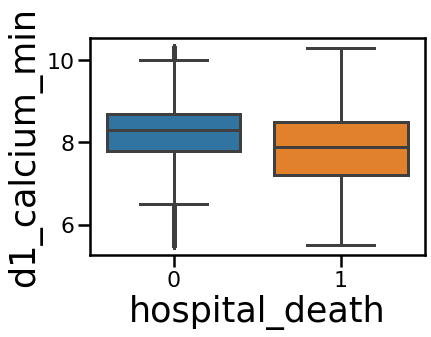

d1_creatinine_max


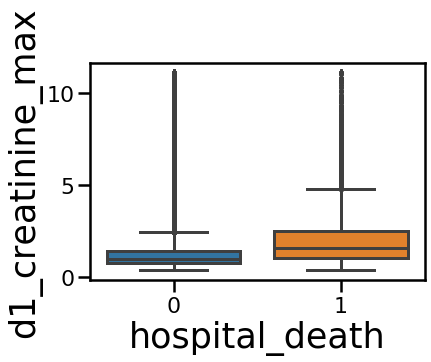

d1_creatinine_min


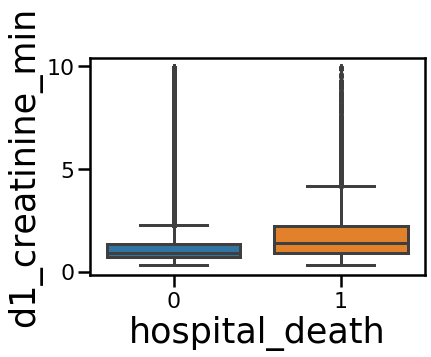

d1_glucose_max


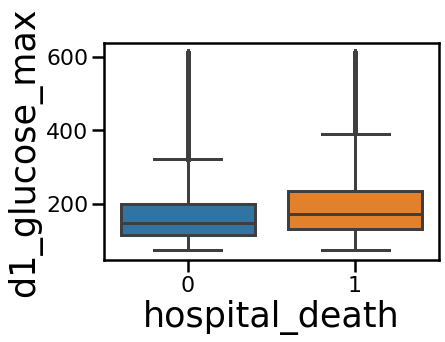

d1_glucose_min


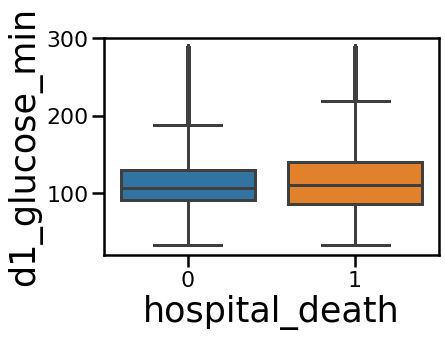

d1_hco3_max


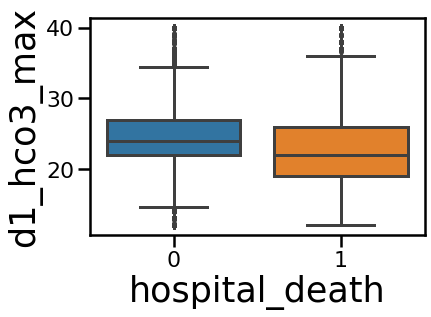

d1_hco3_min


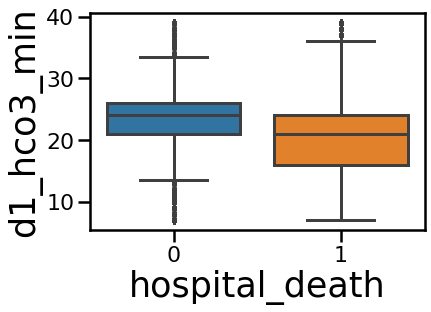

d1_hemaglobin_max


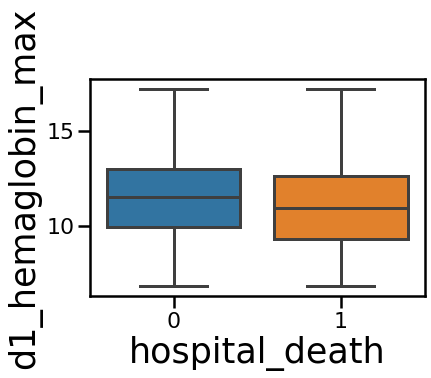

d1_hemaglobin_min


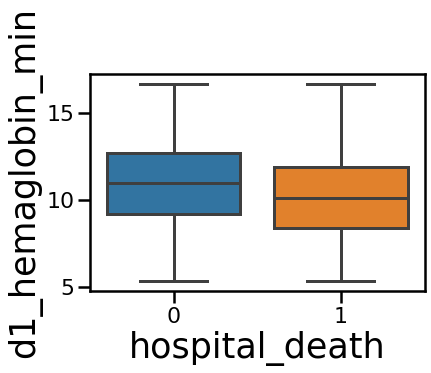

d1_hematocrit_max


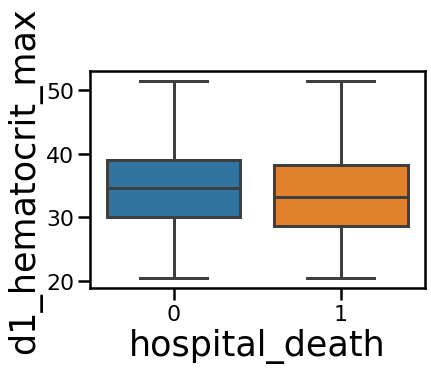

d1_hematocrit_min


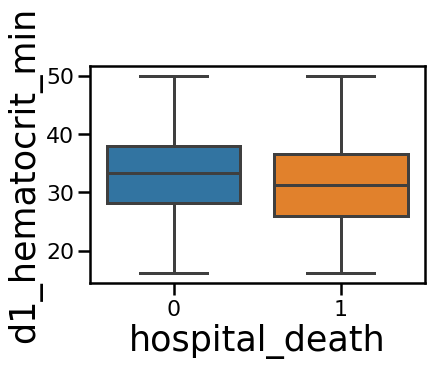

d1_platelets_max


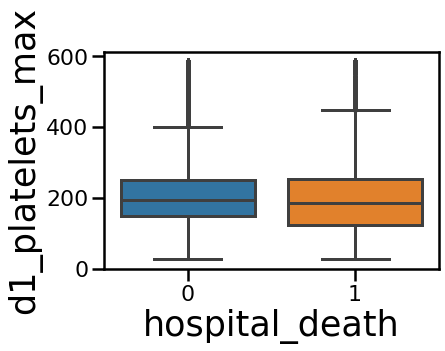

d1_platelets_min


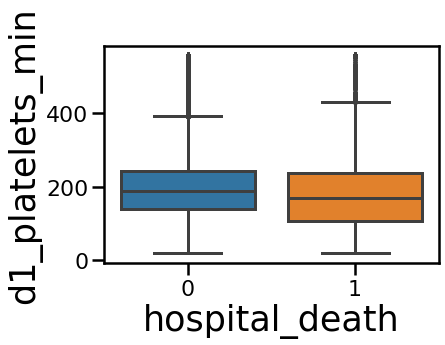

d1_potassium_max


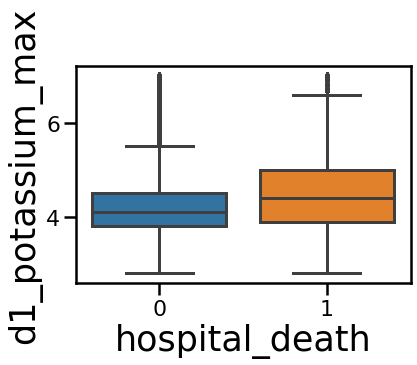

d1_potassium_min


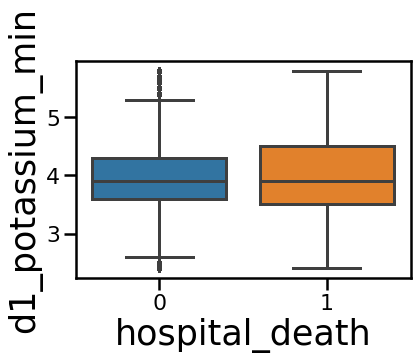

d1_sodium_max


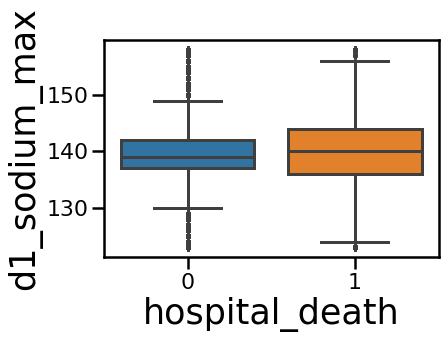

d1_sodium_min


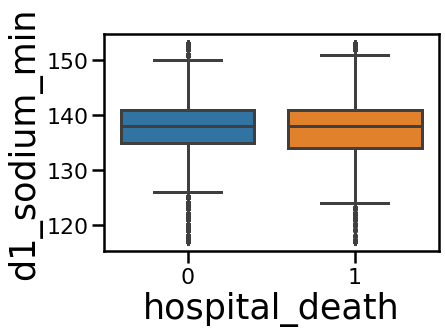

d1_wbc_max


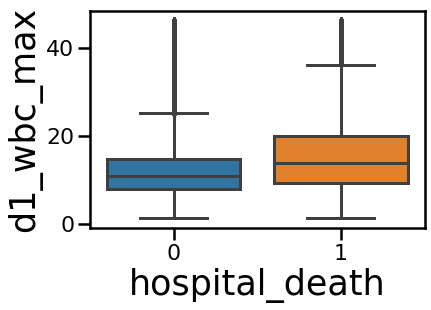

d1_wbc_min


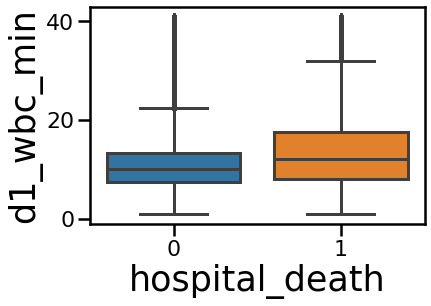

apache_4a_hospital_death_prob


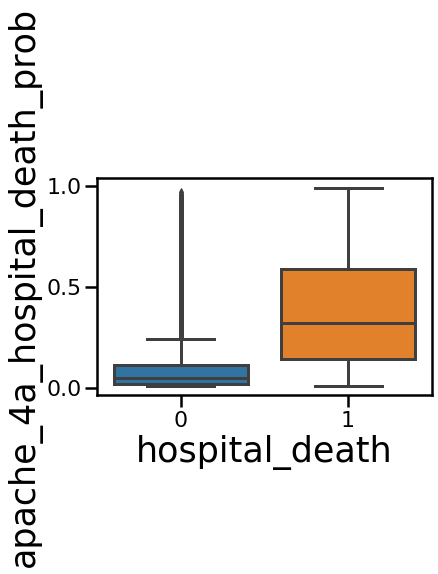

apache_4a_icu_death_prob


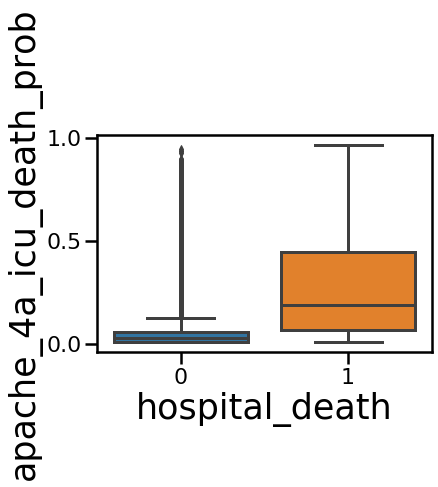

aids


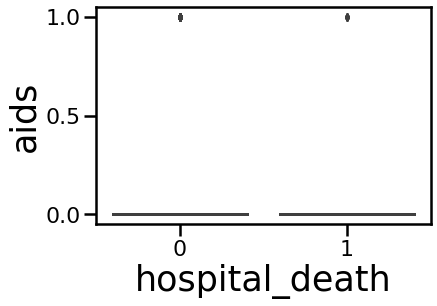

cirrhosis


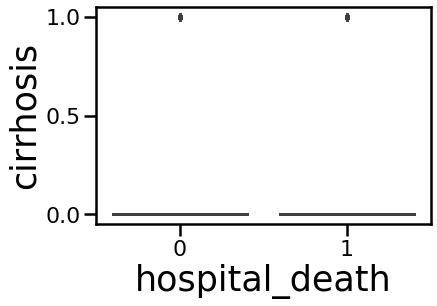

diabetes_mellitus


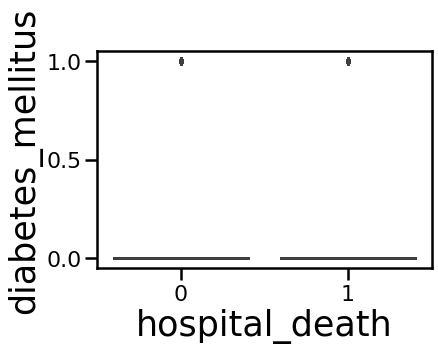

hepatic_failure


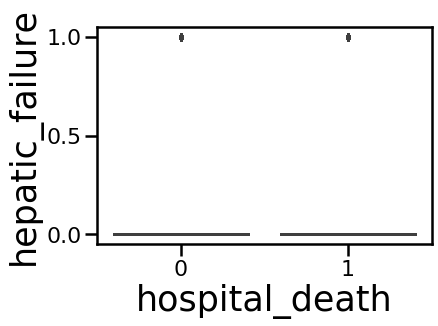

immunosuppression


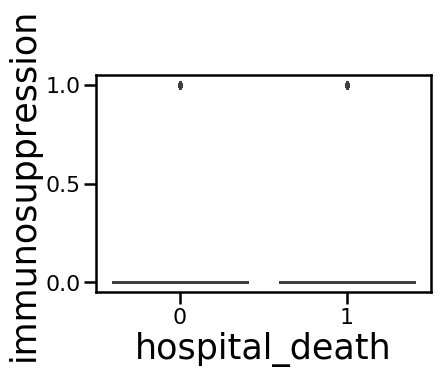

leukemia


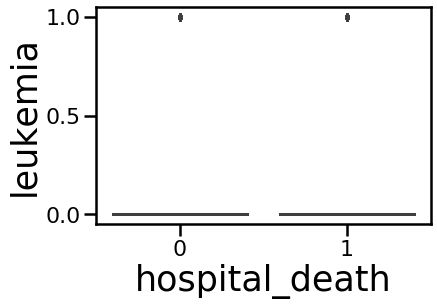

lymphoma


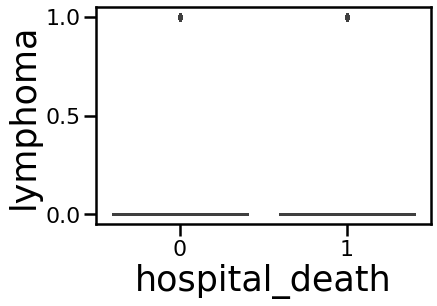

solid_tumor_with_metastasis


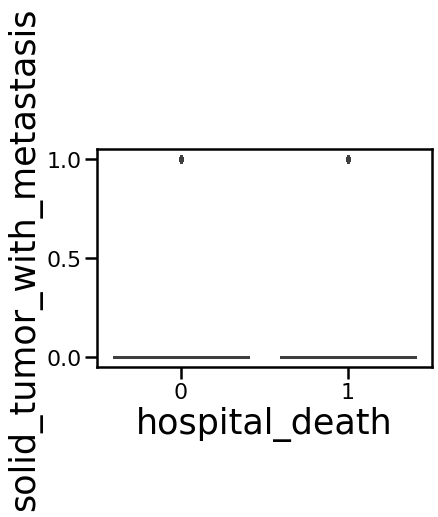

apache_3j_bodysystem


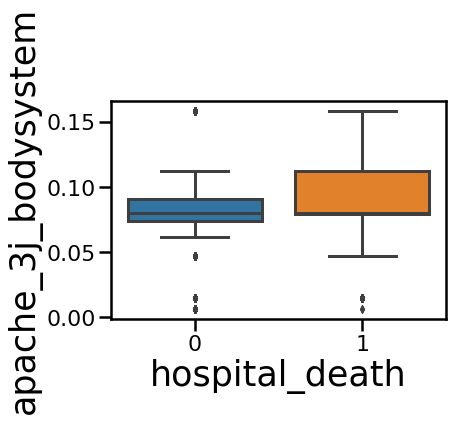

apache_2_bodysystem


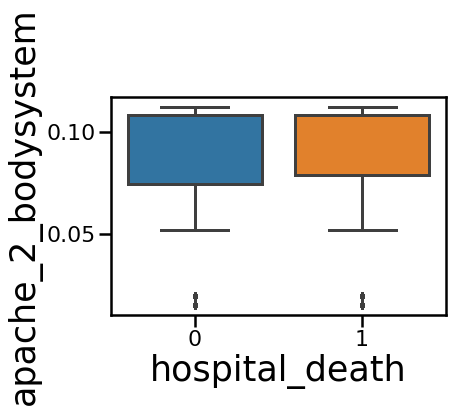

na_count


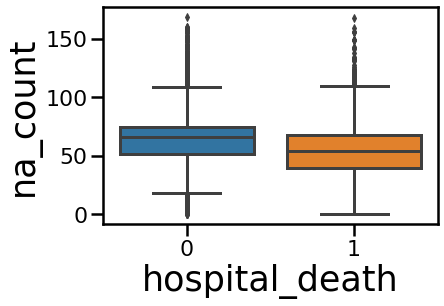

param_25_diff_count


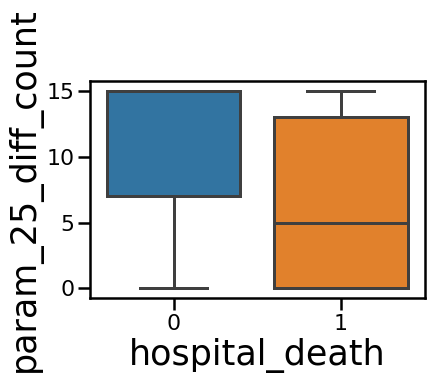

disease_count


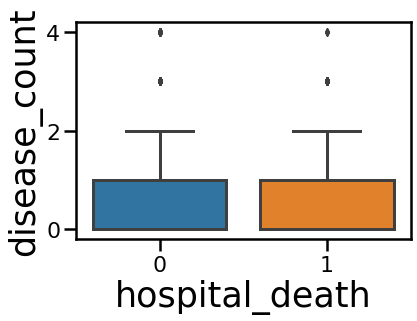

In [34]:
data = train_supplied_missing_catenc.copy()

for param in data.columns.values:
    print(param)
    sns.boxplot(x="hospital_death", y=param, data=data)
    #sns.boxplot(data[data['hospital_death'] == 0][param].dropna())
    #sns.boxplot(data[data['hospital_death'] == 1][param].dropna())
    plt.show()
    
train_supplied_missing_catenc = train_supplied_missing_catenc[train_supplied_missing_catenc['pre_icu_los_days'] < 100]
train_supplied_missing_catenc = train_supplied_missing_catenc[train_supplied_missing_catenc['h1_resprate_min'] < 150]

In [ ]:
['bmi', 
 'arf_apache',
 'bun_apache', 
 'creatinine_apache', 
 'glucose_apache', 
 'heart_rate_apache', 
 'hematocrit_apache',
 'intubated_apache', 
 'map_apache', 
 'resprate_apache',
 'sodium_apache', 
 'temp_apache', 
 'ventilated_apache', 
 'wbc_apache',
 
 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 
 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',

 'd1_heartrate_max', 'd1_heartrate_min', 
 'h1_heartrate_max', 'h1_heartrate_min',
 
 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
 
 'd1_resprate_max', 'd1_resprate_min', 
 'h1_resprate_max', 'h1_resprate_min',
 
 'd1_spo2_max', 'd1_spo2_min',
 'h1_spo2_max', 'h1_spo2_min',
 
 'd1_temp_max', 'd1_temp_min',       
 'h1_temp_max', 'h1_temp_min',
 
 'd1_bun_max', 'd1_bun_min', 
 'd1_calcium_max', 'd1_calcium_min',
 'd1_creatinine_max', 'd1_creatinine_min', 
 'd1_glucose_max', 'd1_glucose_min', 
 'd1_hco3_max', 'd1_hco3_min',
 'd1_hemaglobin_max', 'd1_hemaglobin_min', 
 'd1_hematocrit_max', 'd1_hematocrit_min', 
 'd1_platelets_max', 'd1_platelets_min',
 'd1_potassium_max', 'd1_potassium_min', 
 'd1_sodium_max', 'd1_sodium_min', 
 'd1_wbc_max', 'd1_wbc_min']

In [ ]:
unlabeled_supplied = pd.read_csv(unlabeled_data_path)
unlabeled_supplied = pd.DataFrame(data = unlabeled_supplied)

print('Original data shape:\n', unlabeled_supplied.shape, '\n')

#remove columns with meta data (e.g. unique identifiers)
unlabeled_supplied = unlabeled_supplied.drop(columns = meta_cols)

#convert negative numbers to nans 
unlabeled_supplied.loc[~(unlabeled_supplied['pre_icu_los_days'] > 0), 'pre_icu_los_days']=np.nan
unlabeled_supplied.loc[~(unlabeled_supplied['apache_4a_hospital_death_prob'] > 0), 'apache_4a_hospital_death_prob']=np.nan
unlabeled_supplied.loc[~(unlabeled_supplied['apache_4a_icu_death_prob'] > 0), 'apache_4a_icu_death_prob']=np.nan

#remove features that have more than 50% missing data
print(unlabeled_supplied.shape)
test_missing = (unlabeled_supplied.isnull().sum() / len(unlabeled_supplied)).sort_values(ascending = False)
test_missing = test_missing.index[test_missing > 0.50]
print('There are %d columns with more than 50%% missing values' % len(test_missing))
unlabeled_supplied_missing = unlabeled_supplied.copy().drop(columns = test_missing)
print(unlabeled_supplied_missing.shape)

#encode cat variables
unlabeled_supplied_missing_catenc = enc.transform(unlabeled_supplied_missing)

unlabeled_supplied_missing_catenc.head()

In [ ]:
#create new features that are min max differences
data = train_supplied_cat_missing.copy()
data['d1_bun_diff'] = data['d1_bun_max'] - data['d1_bun_min']
data['d1_heartrate_diff'] = data['d1_heartrate_max'] - data['d1_heartrate_min']
data['d1_wbc_diff'] = data['d1_wbc_max'] - data['d1_wbc_min']
data['d1_temp_diff'] = data['d1_temp_max'] - data['d1_temp_min']
data['d1_spo2_diff'] = data['d1_spo2_max'] - data['d1_spo2_min']
data['d1_sysbp_diff'] = data['d1_sysbp_max'] - data['d1_sysbp_min']

data[['hospital_death', 'd1_bun_diff', 'd1_heartrate_diff', 'd1_wbc_diff', 'd1_temp_diff', 'd1_spo2_diff', 'd1_sysbp_diff']].corr()

In [ ]:
train_supplied_cat_missing.columns.values

In [ ]:
#min max difference 
train_supplied_cat_missing.corr()['hospital_death'].sort_values(ascending=False)

In [ ]:
features = ['hospital_death', 'd1_bun_diff', 'd1_heartrate_diff', 'd1_wbc_diff', 'd1_temp_diff', 'd1_spo2_diff', 'd1_sysbp_diff', 'gcs_motor_apache', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'apache_3j_diagnosis', 'apache_2_diagnosis',
'ventilated_apache', 'intubated_apache']

In [ ]:
#organize param names

data_meta = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id']

param_cat = ['ethnicity', 'gender', 'icu_admit_source', 'hospital_admit_source', 'icu_stay_type', 'icu_type', 
       'apache_3j_bodysystem', 'apache_2_bodysystem']

param_baics_apache = ['age', 'bmi', 'height', 'weight', 'pre_icu_los_days',
                      'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
 'albumin_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache',
       'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
       'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache',
       'hematocrit_apache',  'map_apache',
       'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache',
       'resprate_apache', 'sodium_apache', 'temp_apache',
       'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'elective_surgery', 'readmission_status', 'arf_apache', 'apache_post_operative', 'intubated_apache',
        'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis']
 
param_vitals = ['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min',
       'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max',
       'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_invasive_max',
       'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_temp_min', 'h1_diasbp_invasive_max',
       'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_invasive_max',
       'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min',
       'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
       'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_max',
       'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min']
       
param_labs = ['d1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max',
       'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max',
       'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min',
       'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min',
       'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max',
       'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max',
       'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min',
       'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max',
       'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max',
       'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min',
       'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min',
       'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max',
       'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min',
       'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max',
       'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max',
       'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min',
       'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max',
       'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min']

param_labs_blood = ['d1_arterial_pco2_max', 'd1_arterial_pco2_min',
       'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_po2_max',
       'd1_arterial_po2_min', 'd1_pao2fio2ratio_max',
       'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max',
       'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min',
       'h1_arterial_po2_max', 'h1_arterial_po2_min',
       'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min']

### Feature selection for continuous variables

In [ ]:
#explore autocorrelation across data set
corr = data[param_baics_apache].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(31, 31))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="YlGnBu", robust=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [ ]:
#remove non-invasive and invasive (highly corr with regular measure), only use d1 (not h1 - lots of missing and corr with d1)
features_comb = ['hospital_death', 'ethnicity', 'gender', 'icu_admit_source', 'hospital_admit_source', 'icu_stay_type', 'icu_type', 
       'apache_3j_bodysystem', 'apache_2_bodysystem', 
                 'age', 'bmi', 
                 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
                 'fio2_apache',
                 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 
                 'urineoutput_apache', 'ventilated_apache', 'elective_surgery', 'intubated_apache',
                 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 
                 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis',
                 'd1_diasbp_max', 'd1_diasbp_min', 
                   'd1_heartrate_max', 'd1_heartrate_min', 
                   'd1_mbp_max', 'd1_mbp_min', 
                   'd1_resprate_max', 'd1_resprate_min',
                   'd1_spo2_max', 'd1_spo2_min', 
                   'd1_sysbp_max', 'd1_sysbp_min',
                   'd1_temp_max', 'd1_temp_min',
                 'd1_albumin_max', 'd1_albumin_min', 
              'd1_bilirubin_max', 'd1_bilirubin_min', 
              'd1_bun_max', 'd1_bun_min', 
              'd1_calcium_max', 'd1_calcium_min', 
              'd1_creatinine_max', 'd1_creatinine_min',
              'd1_glucose_max', 'd1_glucose_min', 
              'd1_hco3_max', 'd1_hco3_min',
              'd1_hemaglobin_max', 'd1_hemaglobin_min', 
              'd1_hematocrit_max', 'd1_hematocrit_min', 
              'd1_inr_max', 'd1_inr_min', 
              'd1_lactate_max', 'd1_lactate_min', 
              'd1_platelets_max', 'd1_platelets_min',
              'd1_potassium_max', 'd1_potassium_min', 
              'd1_sodium_max', 'd1_sodium_min', 
              'd1_wbc_max', 'd1_wbc_min',
                 'd1_arterial_pco2_max', 'd1_arterial_pco2_min',
                    'd1_arterial_ph_max', 'd1_arterial_ph_min', 
                    'd1_arterial_po2_max', 'd1_arterial_po2_min', 
                    'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min']

In [ ]:
#explore autocorrelation across data set
corr = data[features_comb].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(33, 19))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="YlGnBu", robust=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Categorical viz and encoding - cat variables are important in health so want to encode using model instead of one-hot etc.

In [ ]:
for param in data[param_cat]:
    print(param)

    data_int = (data.groupby('hospital_death')[param].value_counts() /
                        data.groupby('hospital_death')[param].count()).reset_index(name='perc')
        
    try:
        g = sns.catplot(x=param, y='perc', kind='bar', data=data_int, hue='hospital_death', ci=68, height=5, aspect=4)
        plt.show()
        
        print('\n')
        
    except:
        pass

In [ ]:
#encode categorical variables using m_estimate
data_cat_train = data[features_comb]

Y_train = data_cat_train['hospital_death']
X_train = data_cat_train[features_comb]


# use target encoding to encode two categorical features
enc = ce.TargetEncoder(cols=param_cat)
cat_enc_data = enc.fit_transform(X_train, Y_train)

In [ ]:
#explore autocorrelation across data set
corr = cat_enc_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(33, 19))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="YlGnBu", robust=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Impute missing data

In [ ]:
#use missingo to viz missing data
msno.heatmap(cat_enc_data)

In [ ]:
#impute missing data for features

params = param_baics_apache
imp = IterativeImputer(max_iter=9, random_state=39, verbose=2)
cat_enc_data_imp = imp.fit_transform(cat_enc_data)

In [ ]:
final_data = pd.DataFrame(data=cat_enc_data_imp, columns=cat_enc_data.columns.values)

In [ ]:
final_data.to_csv('final_data.csv')

In [ ]:
final_data.head()

### Model training

In [ ]:
features = ['ethnicity', 'gender', 'icu_admit_source', 'hospital_admit_source', 'icu_stay_type', 'icu_type', 
       'apache_3j_bodysystem', 'apache_2_bodysystem', 
                 'age', 'bmi', 
                 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
                 'fio2_apache',
                 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 
                 'urineoutput_apache', 'ventilated_apache', 'elective_surgery', 'intubated_apache',
                 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 
                 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis',
                 'd1_diasbp_max', 'd1_diasbp_min', 
                   'd1_heartrate_max', 'd1_heartrate_min', 
                   'd1_mbp_max', 'd1_mbp_min', 
                   'd1_resprate_max', 'd1_resprate_min',
                   'd1_spo2_max', 'd1_spo2_min', 
                   'd1_sysbp_max', 'd1_sysbp_min',
                   'd1_temp_max', 'd1_temp_min',
                 'd1_albumin_max', 'd1_albumin_min', 
              'd1_bilirubin_max', 'd1_bilirubin_min', 
              'd1_bun_max', 'd1_bun_min', 
              'd1_calcium_max', 'd1_calcium_min', 
              'd1_creatinine_max', 'd1_creatinine_min',
              'd1_glucose_max', 'd1_glucose_min', 
              'd1_hco3_max', 'd1_hco3_min',
              'd1_hemaglobin_max', 'd1_hemaglobin_min', 
              'd1_hematocrit_max', 'd1_hematocrit_min', 
              'd1_inr_max', 'd1_inr_min', 
              'd1_lactate_max', 'd1_lactate_min', 
              'd1_platelets_max', 'd1_platelets_min',
              'd1_potassium_max', 'd1_potassium_min', 
              'd1_sodium_max', 'd1_sodium_min', 
              'd1_wbc_max', 'd1_wbc_min',
                 'd1_arterial_pco2_max', 'd1_arterial_pco2_min',
                    'd1_arterial_ph_max', 'd1_arterial_ph_min', 
                    'd1_arterial_po2_max', 'd1_arterial_po2_min', 
                    'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min']

features_diff = ['hospital_death', 'd1_bun_diff', 'd1_heartrate_diff', 'd1_wbc_diff', 'd1_temp_diff', 'd1_spo2_diff', 'd1_sysbp_diff', 'gcs_motor_apache', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'apache_3j_diagnosis', 'apache_2_diagnosis',
'ventilated_apache', 'intubated_apache']

#split data
train, test = train_test_split(data, test_size = .3, random_state=1, stratify = data['hospital_death'])

Y_train = train['hospital_death']
Y_test = test['hospital_death']


X_train = train[features_diff]
X_test = test[features_diff]


In [ ]:
#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=10)

#classifier algos
dm_cv = DummyClassifier(strategy='stratified', random_state=39)
lr_cv = LogisticRegression(random_state=39, class_weight='balanced')
rf_cv = RandomForestClassifier(random_state=39, class_weight='balanced')
svm_cv = SVC(kernel='linear', probability=True, class_weight='balanced') 
knn_cv = KNeighborsClassifier()
ab_cv = AdaBoostClassifier(random_state=39)

#dic with classifier and feature importance attribute name
models_dic = {'dm_cv': (dm_cv, 'none'), 
              'lr_cv': (lr_cv, 'coef'), 
              'rf_cv': (rf_cv, 'feature_importance'), 
              'svm_cv':(svm_cv, 'coef'), 
              'knn_cv': (knn_cv, 'none'),  
              'ab_cv': (ab_cv, 'feature_importance')}

#gb_cv = GradientBoostingClassifier(random_state=39)
#'gb_cv': (gb_cv, 'feature_importance'),

In [ ]:
def feature_importance(X, y, model_instance, feature_names, fi_name):
    #takes in features (X) and classess (y), model, column names for features in X, and name of attribute for feature importance
    #returns dictionary of feature names and coef/feature importance values
    
    feature_importance_dic = {}
    
    model_instance.fit(X, y)
    
    if fi_name == 'coef':
        coef = model_instance.coef_[0]
        feature_importance_dic = dict(zip(feature_names, coef))
    if fi_name == 'feature_importance':
        coef = model_instance.feature_importances_
        feature_importance_dic = dict(zip(feature_names, coef))
    if fi_name == 'none':
        coef = np.zeros(len(feature_names))
        feature_importance_dic = dict(zip(feature_names, coef))
    
    return feature_importance_dic

In [ ]:
def classification_pipeline(X, y, cv_instance, model_instance, feature_names, fi_name):
    
    #scale data
    data_scaled = scaler.fit_transform(X)
    
    #generate cross-val sets
    cv = list(cv_instance.split(data_scaled, y))
    
    #predict class and predict probability 
    y_pred = cross_val_predict(model_instance, data_scaled, y, cv=cv, method='predict')
    y_pred_prob = cross_val_predict(model_instance, data_scaled, y, cv=cv, method='predict_proba')
    
    #generate confusion matrix
    conf_mat = confusion_matrix(y, y_pred)
    print('Confusion matrix:', conf_mat)
    
    #generate ROC_AUC
    ROC_AUC = metrics.roc_auc_score(y, y_pred_prob[:,1])
    print("ROC_AUC: ", ROC_AUC)
    
    # generate additional metrics
    recall = metrics.recall_score(y,y_pred)
    precision = metrics.precision_score(y,y_pred)
    accuracy = metrics.accuracy_score(y,y_pred)
    F1 = metrics.f1_score(y,y_pred)
    print("Sensitivity/Recall (TPR): ",recall)
    print("Precision (PPV): ", precision)
    print("Accuracy: ", accuracy)
    print("F1:", F1)
    
    #determine feature importance
    feature_dic = feature_importance(data_scaled, y, model_instance, feature_names, fi_name)
    
    #create dic
    data_dic = {}
    data_dic['y_pred'] = y_pred
    data_dic['y_pred_prob'] = y_pred_prob
    data_dic['conf_mat'] = conf_mat
    data_dic['ROC_AUC'] = ROC_AUC
    data_dic['recall'] = recall
    data_dic['precision'] = precision
    data_dic['accuracy'] = accuracy
    data_dic['F1'] = F1
    
    data_dic = {**data_dic, **feature_dic}
    
    return data_dic

In [ ]:
feature_set = 'full'
feature_names = features_diff

data_full_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_full_features[name + '_' + feature_set] = classification_pipeline(X_train, Y_train, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

In [ ]:
#put dics in pandas df 
final_dic = {**data_full_features}
data_pandas = pd.DataFrame.from_dict(data = final_dic, orient='index')
data_pandas.sort_values('precision', ascending=False).head()

In [ ]:
fpr_dm, tpr_dm, thresholds_dm = metrics.roc_curve(Y_train_class, data_full_features['dm_cv_ave']['y_pred_prob'][:,1])
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(Y_train_class, data_full_features['lr_cv_ave']['y_pred_prob'][:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(Y_train_class, data_full_features['rf_cv_ave']['y_pred_prob'][:,1])
fpr_gb, tpr_gb, thresholds_gb = metrics.roc_curve(Y_train_class, data_full_features['gb_cv_ave']['y_pred_prob'][:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(Y_train_class, data_full_features['svm_cv_ave']['y_pred_prob'][:,1])
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(Y_train_class, data_full_features['knn_cv_ave']['y_pred_prob'][:,1])
fpr_ab, tpr_ab, thresholds_ab = metrics.roc_curve(Y_train_class, data_full_features['ab_cv_ave']['y_pred_prob'][:,1])

# plot model ROC curves
plt.plot(fpr_dm, tpr_dm, label="dm")
plt.plot(fpr_lr, tpr_lr, label="lr")
plt.plot(fpr_rf, tpr_rf, label="rf")
plt.plot(fpr_gb, tpr_gb, label="gb")
plt.plot(fpr_svm, tpr_svm, label="svm")
plt.plot(fpr_knn, tpr_knn, label="knn")
plt.plot(fpr_ab, tpr_ab, label="ada")

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

In [ ]:
# calculate precision-recall curve
precision_dm, recall_dm, thresholds_pr_dm = metrics.precision_recall_curve(Y_train_class, data_full_features['dm_cv_ave']['y_pred_prob'][:,1])
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(Y_train_class, data_full_features['lr_cv_ave']['y_pred_prob'][:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(Y_train_class, data_full_features['rf_cv_ave']['y_pred_prob'][:,1])
precision_gb, recall_gb, thresholds_pr_gb = metrics.precision_recall_curve(Y_train_class, data_full_features['gb_cv_ave']['y_pred_prob'][:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(Y_train_class, data_full_features['svm_cv_ave']['y_pred_prob'][:,1])
precision_knn, recall_knn, thresholds_pr_knn = metrics.precision_recall_curve(Y_train_class, data_full_features['knn_cv_ave']['y_pred_prob'][:,1])
precision_ab, recall_ab, thresholds_pr_ab = metrics.precision_recall_curve(Y_train_class, data_full_features['ab_cv_ave']['y_pred_prob'][:,1])

plt.plot(recall_dm, precision_dm, label='dm')
plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_gb, precision_gb, label='gb')
plt.plot(recall_svm, precision_svm, label='svm')
plt.plot(recall_knn, precision_knn, label='knn')
plt.plot(recall_ab, precision_ab, label='ada')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

save final model using pickle

In [ ]:
import pickle
#pickel model to save for later use
save_path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Ferguson/'

pkl_filename = str(save_path + "5day_ave_lr.pkl")  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(lr_cv, file)

grid searches

In [ ]:
#scale data for grid search
train_scaled = scaler.fit_transform(X_train_full)

#grid search with cv for gb and full features
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 4),
    "min_samples_leaf": np.linspace(0.1, 0.5, 4),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[10]
    }

scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

gb_base = GradientBoostingClassifier(random_state=39)

gb_gs = GridSearchCV(gb_base, param_grid, scoring='accuracy', cv=3, refit='f1')
gb_gs.fit(train_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(gb_gs, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(gb_gs, train_scaled, Y_train_class, scoring='roc_auc'))))

print(gb_gs.best_params_)

In [ ]:
#use best params
train_scaled = scaler.fit_transform(X_train_full)

gb_best = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss='deviance', max_depth=3, max_features='log2', min_samples_leaf= 0.25, min_samples_split=0.1, n_estimators=10, subsample=0.8, random_state=39)
    
print("f1:"+str(np.average(cross_val_score(gb_best, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(gb_best, train_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(gb_best, train_scaled, Y_train_class, scoring='accuracy'))))

gb_best.fit(train_scaled, Y_train_class)
print(gb_best.score(train_scaled, Y_train_class))

train_pred_gb = gb_best.predict(train_scaled)
train_pred_prob_gb = gb_best.predict_proba(train_scaled)
print(classification_report(Y_train_class, train_pred_gb))
print(confusion_matrix(Y_train_class, train_pred_gb))

In [ ]:
#scale data for grid search
train_scaled = scaler.fit_transform(X_train_ave)

#grid search with cv for svm and ave features
param_grid = {'C':(0.001, 0.01, 0.1, 1, 10), 'decision_function_shape':('ovo','ovr'), 'kernel':('linear', 'rbf')}
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

svm_base = SVC(class_weight='balanced', random_state=39)

svm_gs = GridSearchCV(svm_base, param_grid, cv=3, scoring = scoring, refit='f1')
svm_gs.fit(train_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(svm_gs, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_gs, train_scaled, Y_train_class, scoring='roc_auc'))))

print(svm_gs.best_params_)

In [ ]:
#use best params
train_scaled = scaler.fit_transform(X_train_ave)

svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', C=1, decision_function_shape='ovo', random_state=39)
    
print("f1:"+str(np.average(cross_val_score(svm_best, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_best, train_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(svm_best, train_scaled, Y_train_class, scoring='accuracy'))))

svm_best.fit(train_scaled, Y_train_class)
print(svm_best.score(train_scaled, Y_train_class))

train_pred_svm = svm_best.predict(train_scaled)
train_pred_prob_svm = svm_best.predict_proba(train_scaled)
print(classification_report(Y_train_class, train_pred_svm))
print(confusion_matrix(Y_train_class, train_pred_svm))

In [ ]:
#grid search with cv for rf and ave features
train_scaled = scaler.fit_transform(X_train_ave)

param_grid = { 
    'n_estimators': [5, 10, 50, 100, 500],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,None],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [True, False]
}

scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

rf_base = RandomForestClassifier(class_weight='balanced', random_state=39)

rf_gs = GridSearchCV(rf_base, param_grid, cv=10, scoring = scoring, refit='f1')
rf_gs.fit(train_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(rf_gs, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(rf_gs, train_scaled, Y_train_class, scoring='roc_auc'))))

print(rf_gs.best_params_)

In [ ]:
#use best params
train_scaled = scaler.fit_transform(X_train_ave)

rf_best = RandomForestClassifier(class_weight='balanced', random_state=39)

print("f1:"+str(np.average(cross_val_score(rf_best, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(rf_best, train_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(rf_best, train_scaled, Y_train_class, scoring='accuracy'))))

rf_best.fit(train_scaled, Y_train_class)
print(rf_best.score(train_scaled, Y_train_class))

train_pred_rf = rf_best.predict(train_scaled)
train_pred_prob_rf = rf_best.predict_proba(train_scaled)
print(classification_report(Y_train_class, train_pred_rf))
print(confusion_matrix(Y_train_class, train_pred_rf))

In [ ]:
#run on test data with best optimized model
#scale data
test_scaled = scaler.fit_transform(X_test_ave)

print('GB test AUC: {}'.format(lr_cv.score(test_scaled, Y_test_class)))
test_pred_gb = lr_cv.predict(test_scaled)
test_pred_prob_gb = lr_cv.predict_proba(test_scaled)
print(classification_report(Y_test_class, test_pred_gb))
print(confusion_matrix(Y_test_class, test_pred_gb))

### Unsupervised clustering

In [ ]:
# center and scale the data
scaler = StandardScaler()

features_clust_scaled = scaler.fit_transform(data[features_ave])

In [ ]:
k_range = range(2,10)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(features_clust_scaled)
    scores.append(silhouette_score(features_clust_scaled, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [ ]:
km2 = KMeans(n_clusters=2,random_state=1234)
km2.fit(features_clust_scaled)
data['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
data.groupby('kmeans_2_scaled').mean()

In [ ]:
data.groupby('Severity')['kmeans_2_scaled'].value_counts()